In [1]:
# import libs

import numpy as np
import Laser
import gCode
import random
import Printer
import os


# Important definition
positive angle in CCW direction

### Units
Distances: mm  
Angles: degrees

# Define functions

In [2]:
#GLOBAL VARIABLES FOR DEBUGGING
d = 10

# global variables
firstLayer = 0

laserPWM = 1.00


fanPWM0 = 0.80
fanPWM1 = 1.00

In [3]:
# global debug
asd = []
asdd = []
asr = []

In [4]:
# read G-Code file and return a list of strings
def read_gcode_file(filename):
    tmp = []
    with open(filename, 'r') as f:
        gcode = f.readlines()
    for line in gcode:
        tmp.append(line)
    
    return np.array(tmp)
    

In [5]:
def parseCoord(gCodeObj,linestring):
    line = linestring
    X = None
    Y = None
    Z = None
    E = None
    F = None
    move = False

    # check the command of the gcode line (string until first space)
    command = line.split(' ')[0]

    # check if line is ;LAYER:1 and gCodeObj.firstLayerCheck is False
    if line.startswith(';LAYER:5') and not gCodeObj.firstLayerCheck:
        gCodeObj.updateFirstLayerCheck(True)
        print("First layer check is True")

    # check if FirstLayerCheck == True and a new G1 or G0 command 
    if (gCodeObj.checkFirstLayer):
        if ((command == "G1") or (command == "G0")):
            if (gCodeObj.getHistoryMovementCommandCheck() == False):
                if (gCodeObj.getFirstMovementCommandCheck() == False):
                    gCodeObj.updateFirstMovementCommandCheck(True)
            else:
                gCodeObj.updateFirstMovementCommandCheck(False)


    # check if firstLayerCheck is True -> implented in processGcode
    #if gCodeObj.firstLayerCheck:
    if (1):
        # if command == G1 or G0 than move = True
        if command == 'G1' or command == 'G0':
            move = True
        if command == 'G1':
            gCodeObj.updateNumberOfG1()
            
        # check if line contains ; which means it is a comment or one of the instructions lines in the beginning and needs to be skipped 
        if not ';' in line:
            # parse the X Y Z coords from string to float, and the values of F and E
            if 'X' in line:
                X = float(line.split('X')[-1].split(' ')[0])
                gCodeObj.lastX = X
            elif 'X' not in line:
                X = None
                X = gCodeObj.lastX
            if 'Y' in line:
                Y = float(line.split('Y')[-1].split(' ')[0])
                gCodeObj.lastY = Y
            elif 'Y' not in line:
                Y = None
                Y = gCodeObj.lastY
            if 'Z' in line:
                Z = float(line.split('Z')[-1].split(' ')[0])
                gCodeObj.lastZ = Z
            elif 'Z' not in line:
                Z = None
                Z = gCodeObj.lastZ
            if 'E' in line:
                E = float(line.split('E')[-1].split(' ')[0])
                gCodeObj.lastE = E
            elif 'E' not in line:
                E = None
                E = gCodeObj.lastE
            if 'F' in line:
                F = float(line.split('F')[-1].split(' ')[0])
                gCodeObj.lastF = F
            elif 'F' not in line:
                F = None
                F = gCodeObj.lastF
    else:
        X = None
        Y = None
        Z = None
        E = None
        F = None
    return move, X, Y, Z, E, F, command, linestring


In [6]:
# calculate the distance between two points
def calcDistance(x0, y0, x1, y1, lineNumber):
    try:
        return np.sqrt((x1-x0)**2 + (y1-y0)**2)
    except:
        print("DistanceCALC Error in Line: " +str(lineNumber))
        print(type(x0), type(y0), type(x1), type(y1))
        print(x0, y0, x1, y1)


In [7]:
# calculate angle between two points (atan2)
def calcAngle(x0, y0, x1, y1, lineNumber):
    global asd
    try:
        newAngle = np.arctan2((y1-y0),(x1-x0))
    
        # convert to degrees
        newAngle = np.rad2deg(newAngle)

        # round to 3 decimals
        newAngle = round(newAngle,2)


        # threshold for angle
        if (np.abs(newAngle) < 0.1):
            newAngle = 0.00

        asd.append(newAngle)

        return newAngle
    
    except:
        print("AngleCALC Error in LineNumber: " + str(lineNumber))
    

In [8]:
def findClosestAngle(targetAngle, LaserObj, i):

    global asdd

    targetAngle = np.array(targetAngle)
    currentAngle = LaserObj.getNormAngles()

    # copy angles
    targetAngle_origin = targetAngle
    currentAngle_origin = currentAngle

    # modulate angles with 360
    targetAngle = np.mod(targetAngle, 360)
    currentAngle = np.mod(currentAngle, 360)

    delta = targetAngle - currentAngle
    tmp = np.zeros(np.size(delta))

    # loop through delta array
    for i in range(np.size(delta)):
        d = delta[i]
        if(d < -180):
            d += 360
        elif(d >= 180):
            d -= 360
        tmp[i] = d
    
    delta = tmp

    # find the index of the closest angle
    closestAngleIndx = np.argmin(np.abs(delta))
    deltaAngle = delta[closestAngleIndx]


    if(deltaAngle > 45.5):
        print("Line: " + str(i) + "DeltaAngle is bigger than 5°: " + str(deltaAngle) + " target: " + str(targetAngle))

    # round the values
    deltaAngle = round(deltaAngle, 2)

    asdd.append(deltaAngle)


    return closestAngleIndx, deltaAngle, currentAngle

    

In [9]:

def convertAngleToSteps(angle):
    return angle


In [10]:
def deactivateAllLaser(newFilePath, laserObj, laserStringOffset):
    for l in range(len(laserObj.LaserStates)):
        newLine02 = "M106 P" + str(l+laserStringOffset) + " S0.0    ;deactivateAllLaser\n"
        laserObj.updateLaserStates(l, 0)
        with open(newFilePath, 'a') as f:
            f.write(newLine02)
            f.close()  
    return

In [11]:
def deativateONLaser(newFilePath, laserObj, laserStringOffset):
    for l in range(len(laserObj.LaserStates)):
        if(laserObj.LaserStates[l] == 1):
                # deactivate
                laserObj.updateLaserStates(l, 0)
                deactCmd = "M106 P" + str(l+laserStringOffset) + " S0   ;deactivateONLaser\n"
                with open(newFilePath, 'a') as f:
                    f.write(deactCmd)
                    f.close() 
                

In [12]:
def appendToFile(newFilePath, string):
    with open(newFilePath, 'a') as f:
        f.write(string)
        f.close()
    return

In [13]:
## Function to extract the parsersInformation to a csv
# data to be stored

def save2csv(data, filepath):
    move1, X1, Y1, Z1, E1, F1, A1, dist, delta, command1, line1 = data 

    # if command1 contains "\n" remove it
    if "\n" in command1:
        command1 = command1.replace("\n", "")

    # write to csv file
    with open(filepath, 'a') as f:
        #f.write(str(line1))
        f.write(str(move1) + ";" + str(X1) + ";" + str(Y1) + ";" + str(Z1) + ";" + str(E1) + ";" + str(F1) + ";" + str(A1) + ";" + str(dist) + ";" + str(delta) + ";" + str(command1) + ";" + str(line1) + "\n")
        f.close()



In [14]:
# wuem: thresholdAngleRetract added

def processGcode(gCodeFile, thresholdDistance, thresholdAngle, thresholdAngleRetract, laserObj, newFilePath, gCodeObj):
  
    # number of end lines
    endLines = 11
    layerEnd = 0

    minimalDistThreshold = 0.1

    ### processing parameters
    #  define string offset for physical laser connection
    laserStringOffset = 2

    
    # speeds for G0 and G1
    F0 = 3600
    F1 = 1200

    ### Include start file parameter
    # deactivate all lasers
    deactivateAllLaser(newFilePath=newFilePath, laserObj=laserObj, laserStringOffset=laserStringOffset)

    # add movement to X0.0 Y0.0 Z0.2 for test line bottom left corner
    moveCMD = "G1 X0 Y0 Z0.2"

    # activate fan
    fanPWM = fanPWM0
    activateFanCMD = "M106 P6 S" + str(fanPWM0) + "\n"
    appendToFile(newFilePath, activateFanCMD)

    # laserPWM is set in global variables
    global laserPWM

    if(1):
        csvPath = "Output/debug.csv"
        if os.path.isfile(csvPath):
            # delete file
            os.remove(csvPath)
    
        if not os.path.isfile(csvPath):
            with open(csvPath, 'w') as f:
                f.write("move;X;Y;Z;E;F;A;command;line\n")
                f.close() 

    absAngle = 0


    ### start loop through entire gcode
    for i in range(gCodeFile.shape[0]-endLines):

        tmp = 0

        # step by step
        if (d==1):
            P = 1
            #input()


        # read line and compare to current pos which is saved in gCodeObj
        move1, X1, Y1, Z1, E1, F1, command1, line1 = parseCoord(gCodeObj, gCodeFile[i])

        # if line1 == ;layer4 change fanPWM to fanPWM1 and write line M106 P6 S+str(fanPWM)
        if(line1.startswith(";LAYER:4")):
            fanPWM = fanPWM1
            activateFanCMD = "M106 P6 S" + str(fanPWM) + "\n"
            appendToFile(newFilePath, activateFanCMD)

         # get current pos
        X0, Y0, Z0, A0 = gCodeObj.getCurrentPos()
        A0 = laserObj.getAbsLaserPos()

        
        if(d==1):
            # remove \n from line1
            line1n = line1.replace("\n", "")
            # save data to csv
            save2csv([move1, X1, Y1, Z1, E1, F1, A0,0,0,command1, line1n], csvPath)

        # check for firstMovementCommandCheck and write coords into currentPos, no further processing
        if(gCodeObj.getFirstMovementCommandCheck()):
            gCodeObj.updateCurrentPos([X1, Y1, Z1, 0])
            
        
       

        # if layer is 240 set layerEnd to 1
        if(line1.startswith(";LAYER:296")):
            layerEnd = 1

        if(layerEnd == 0):

            # only execute rotation and laser ON OFF if line is a G1
            if((command1 == "G1" or command1 == "G0") and (gCodeObj.checkFirstLayer())):

                if(d==2):
                    p = 1
                    #print("Command is G1 or G0 and first layer check is True")


                # calculate distance
                try:
                    distance = calcDistance(x0=X0, y0=Y0, x1=X1, y1=Y1, lineNumber=i+1)
                    # update total distance 
                    if(command1 == "G1"):
                        gCodeObj.updateTotalLengthOfG1(distance)

                except:
                    print("Error in calculating distance. Line: " + str(i+1))

                

                # calculate angle
                try:
                    angle = calcAngle(x0=X0, y0=Y0, x1=X1, y1=Y1, lineNumber=i+1)
                except:
                    print("Error in calculating angle. Line: " + str(i+1))
                    angle = gCodeObj.getLastAngle()
                lastAngle = gCodeObj.getLastAngle()

                # normalize the target angle between 0 and 360 degrees
                #try:
                targetAngle = angle

                
                
                # command string will be filled during the if statements
                command = ""

                


                # if command is G0 ensure that no laser is activated
                if(command1 == "G0"):
                    deativateONLaser(newFilePath, laserObj, laserStringOffset)
                    
                if(command1 == "G1"):


                    # find the closest angle to the target angle
                    closestAngleIndx, deltaAngle, currentAngles = findClosestAngle(targetAngle, laserObj,i)
                    print(deltaAngle, i)
                    
                    clstIndx = closestAngleIndx

                    # get absolute angle for rotation command
                    absAngle = laserObj.getAbsLaserPos()

                    # check if any laser is activated, if yes and not the closestIndx than deactivate
                    for l in range(len(laserObj.LaserStates)):
                        if(laserObj.LaserStates[l] == 1):
                            if(l != closestAngleIndx):
                                # deactivate
                                deactCmd = "M106 P" + str(l+laserStringOffset) + " S0\n"
                                appendToFile(newFilePath=newFilePath, string=deactCmd)
                                laserObj.updateLaserStates(l, 0)
                    #print("init Laserstates: " + str(laserObj.LaserStates))


                    if(d==1):
                        print("G1 command, distance: " + str(distance) + " threshold: " + str(thresholdDistance) + " deltaAngle: " + str(deltaAngle) + " threshold: " + str(thresholdAngle)+"\n")
                    
                    
                    
                    if(distance >= thresholdDistance):
                    ### MODE Straights   
                        if(d==1):
                            print("STRAIGHT MODE, Line: " + str(i+1))

                        # update absolute angle
                        absAngle += deltaAngle
                        
                        # update laser angles
                        laserObj.updateAngles(deltaAngle)
                        

                        if (d==1):
                            command+="; STRAIGHT ** Current Pos: X" + str(X0) + " ; Y" + str(Y0) + " ; Z" + str(Z0) + " ; A" + str(A0) + "; Aabs " + str(absAngle) + " dA" + str(deltaAngle) + " calcA" + str(angle) + " target" + str(targetAngle) + " Indx" +str(clstIndx) + "\n"
                            print("Z1: " + str(Z1) + " Line: " + str(i+1))


                        # wuem: if Angle dif < threshold then add a Retract and added round
                        # rotate laser
                        if (abs(deltaAngle) >= thresholdAngleRetract):
                            command += "; Rotate case0" '\n'
                            command += "G1 E-1 F" + str(F0) + '\n'
                            command += "G1 Z" + str(Z1+0.5) + "\n"
                            command += "G0 A" + str(round(absAngle,1)) + '\n'
                            command += "G1 Z" + str(Z1) + "\n"
                            command += "G1 E1 \n"
                            command +=  "G1 F" + str(F1) + "\n"
                        else:
                            command += "; Rotate case1" '\n'
                            command += "G0 F" + str(F0) + " A" + str(round(absAngle,1)) + '\n'
                            command += "G1 F" + str(F1) + "\n" 
    
                        

                        # if laser not turned on yet, activate
                        if(laserObj.getLaserStates(closestAngleIndx) == 0):
                            # activate laser 
                            command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "\n"
                            # update laserstate
                            laserObj.updateLaserStates(closestAngleIndx, 1)

                        if (d==1):
                            command += ";Laserstates " + str(laserObj.LaserStates) + " CurrAngles " + str(laserObj.getNormAngles()) + "\n"
                        # insert G1 line
                        #command += line1 + "\n"
                        # deactivate laser
                        # command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(0.0) + "\n"
                        
                        # update lastAngle   --->3
                        gCodeObj.updateLastAngle(absAngle)


                    elif((abs(deltaAngle) <= thresholdAngle)and(distance < thresholdDistance) and (distance > minimalDistThreshold)):
                    ### MODE Curves
                        global asr
                        asr.append([deltaAngle, distance])
                        print("CURVE MODE, Line: " + str(i+1))

                        # update absolute angle
                        absAngle += deltaAngle

                        # update laser angles
                        laserObj.updateAngles(deltaAngle)

                        # if laser not turned on yet, activate
                        if(laserObj.getLaserStates(closestAngleIndx) == 0):
                            if (d==2):
                                command +=";CURVE MODE**Current Pos: X" + str(X0) + " ; Y" + str(Y0) + " ; Z" + str(Z0) + " ; A" + str(A0) + " Indx" +str(clstIndx) + "\n"
                            # activate laser 
                            command += "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "\n"
                            # update laserstate
                            laserObj.updateLaserStates(closestAngleIndx, 1)

                        


                        # if line1 contains "\n" remove it
                        if "\n" in line1:
                            line1 = line1.replace("\n", "")
                        command += line1 + " A" + str(round(absAngle,1)) #wuem: added round


                        if (d==2):
                            command += " ;CurveMode, Laserstates" + str(laserObj.LaserStates)+ "\n"
                        else:
                            command += "\n"
                            
                        tmp = 1 #wuem: damit unten die line1 nicht noch einmal eingefügt wird.

                        # check if the needed laser is 
                else:
                    # no laser activated
                    tmp = 1
                    command = line1  
                # write to file
                appendToFile(newFilePath=newFilePath, string=command)

                # update currentPos in gCodeObj
            gCodeObj.updateCurrentPos([X1, Y1, Z1, absAngle])

                



                # update states of the lasers
                # if laser not turned on yet, activate
                
                

            if(0):
                    if(laserObj.getLaserStates(closestAngleIndx) == 0):
                        # activate laser 
                        actCmd = "M106 P" + str(closestAngleIndx+laserStringOffset) + " S" + str(laserPWM) + "  ;Line233\n"
                        # update laserstate
                        laserObj.updateLaserStates(closestAngleIndx, 1)
                        with open(newFilePath, 'a') as f:
                            f.write(actCmd)
                            f.close()
                    


            elif(tmp == 0):
                #appendToFile(newFilePath, ";case2"+line1 + ";line1 string is:" + line1)
                #wuem: hier kommt das Problem, dass er die line1 nochmals einfügt, auch wenn er schon einen Rotationsbefehl eingefügt hat.
                appendToFile(newFilePath, line1)

        
        else:
                appendToFile(newFilePath, line1)

        if (d==2):
            try:
                lastCoords = ("X0: " +str(X0) + " Y0: " + str(Y0) + " Z0: " + str(Z0) + " A0: " + str(A0) + "\n")
                
            except:
                lastCoors = ("NO NEW COORDS")
            appendToFile(newFilePath, lastCoords)
        # append last coords to file
        


    # append the last 11 lines
    # check if any laser is on and turn off
    deactivateAllLaser(newFilePath, laserObj, laserStringOffset)
    # append line0 to newFilePath
    with open(newFilePath, 'a') as f:
        f.write(line1)
        f.close()

    for i in range(endLines):
        with open(newFilePath, 'a') as f:
            f.write(gCodeFile[-11+i]+ "\n")
            f.close()


In [15]:
# Add start lines to GCODE


# Test functions

In [16]:
# test calcAngle function
if (0):
    print(calcAngle(0,0,0,0))
    print(calcAngle(0,0,1,-1))
    print(calcAngle(0,0,-1,-1))
    print(calcAngle(0,0,-1,1))


In [17]:
# test the parseCoord function
if(0):

# read the gcode file
    gcode = read_gcode_file("GCODE.txt")

    # create empty lists for the coordinates
    X = []
    Y = []
    Z = []
    cmd = []
    i = 0
    # loop over all lines in the gcode file
    for line in gcode:
        #print(i)
        #i += 1
        # parse the coordinates from the line
        moveBool, x, y, z, command, linestring = parseCoord(line)
        # append the coordinates to the lists
        X.append(x)
        Y.append(y)
        Z.append(z)
        cmd.append(command)

# print first 10 elements of X Y Z
j = 50
if(0):
    for i in range(j):
        print(f"X: {X[i]} Y: {Y[i]} Z: {Z[i]} cmd: {cmd[i]}")

# Main 

In [18]:
# initiate Printer object, for duration calculation of process
Prusa = Printer.Printer(velocity_trans=100, velocity_rot=100)

fileName = "PI3MK3M_Probekörper_rund"

# read the gcode file
gcode = read_gcode_file("Input/"+fileName+".gcode")
gCodeObj = gCode.gCode("gCode")

# print shape of gcode
print(gcode.shape)

# create laser object
numberOfLaser = 4
laser = Laser.Laser(numberOfLaser)

# threshold for the distance between two points 
minDistance = 2.5
# threshold for the angle between two points
minAngle = 10
# threshold for the retract
minAngleRetract = 5

# check index in Output/index.txt
with open("Output/index.txt", 'r') as f:
    index = int(f.read())
    f.close()

# create new file
newFilePath = "Output/" + fileName + "_processed.gcode"

# check if file size is not 0
if os.path.isfile(newFilePath):
    # delete file
    os.remove(newFilePath)


# print LaserStates
print(laser.LaserStates)



# iterate index in Output/index.txt
with open("Output/index.txt", 'w') as f:
    f.write(str(index+1))
    f.close()

# post process the gcode
print(processGcode(gcode, minDistance, minAngle, minAngleRetract, laser, newFilePath, gCodeObj))


(68226,)
[0. 0. 0. 0.]
First layer check is True
0.0 1930
0.0 1931
0.0 1932
0.0 1933
0.0 1935
0.0 1936
0.0 1938
0.0 1939
CURVE MODE, Line: 1940
0.0 1941
0.0 1942
0.0 1944
CURVE MODE, Line: 1945
0.0 1945
0.0 1947
CURVE MODE, Line: 1948
0.0 1948
0.0 1950
CURVE MODE, Line: 1951
0.0 1951
0.0 1953
0.0 1954
0.0 1956
0.0 1957
CURVE MODE, Line: 1958
0.0 1959
0.0 1960
0.0 1962
0.0 1963
0.0 1965
0.0 1966
0.0 1968
0.0 1969
0.0 1971
CURVE MODE, Line: 1972
0.0 1972
0.0 1974
CURVE MODE, Line: 1975
0.0 1975
0.0 1977
CURVE MODE, Line: 1978
0.0 1978
0.0 1980
0.0 1981
CURVE MODE, Line: 1982
0.0 1983
0.0 1984
8.16 1987
CURVE MODE, Line: 1988
10.6 1988
24.42 1989
34.52 1990
-40.82 1991
-32.64 1992
-24.53 1993
-12.98 1994
-5.2 1995
CURVE MODE, Line: 1996
10.39 1996
21.63 1997
34.95 1998
44.45 1999
-35.61 2000
-21.69 2001
-11.1 2002
0.72 2003
CURVE MODE, Line: 2004
7.59 2004
CURVE MODE, Line: 2005
13.44 2005
26.53 2006
33.73 2007
40.91 2008
-35.86 2009
-25.7 2010
-16.03 2011
-8.31 2012
CURVE MODE, Line: 201

0.0 4306
0.0 4308
CURVE MODE, Line: 4309
0.0 4309
0.0 4311
CURVE MODE, Line: 4312
0.0 4312
0.0 4314
CURVE MODE, Line: 4315
0.0 4315
0.0 4317
CURVE MODE, Line: 4318
0.0 4318
0.0 4320
0.0 4321
0.0 4323
0.0 4324
CURVE MODE, Line: 4325
0.0 4326
0.0 4327
0.0 4329
0.0 4330
CURVE MODE, Line: 4331
0.0 4332
CURVE MODE, Line: 4333
0.0 4333
0.0 4335
CURVE MODE, Line: 4336
0.0 4336
CURVE MODE, Line: 4337
0.0 4338
CURVE MODE, Line: 4339
0.0 4339
0.0 4341
CURVE MODE, Line: 4342
0.0 4342
0.0 4344
CURVE MODE, Line: 4345
0.0 4345
0.0 4347
0.0 4348
0.0 4350
0.0 4351
0.0 4353
0.0 4354
-35.74 4368
-27.71 4369
-20.44 4370
-13.14 4371
-4.64 4372
CURVE MODE, Line: 4373
7.81 4373
CURVE MODE, Line: 4374
10.0 4374
CURVE MODE, Line: 4375
8.25 4375
CURVE MODE, Line: 4376
8.32 4376
CURVE MODE, Line: 4377
7.03 4377
CURVE MODE, Line: 4378
7.07 4378
CURVE MODE, Line: 4379
10.45 4379
18.41 4380
25.79 4381
32.8 4382
42.3 4383
-39.47 4384
-31.51 4385
-24.44 4386
-14.17 4387
-6.26 4388
CURVE MODE, Line: 4389
7.42 4389
CU

-26.88 7425
-16.66 7426
-7.99 7427
CURVE MODE, Line: 7428
12.78 7428
25.34 7429
34.11 7430
44.23 7431
-35.33 7432
-26.74 7433
-14.02 7434
-5.44 7435
CURVE MODE, Line: 7436
10.22 7436
22.76 7437
35.54 7438
-41.85 7439
-33.12 7440
-22.87 7441
-10.3 7442
2.3 7443
CURVE MODE, Line: 7444
12.77 7444
25.25 7445
38.0 7446
-39.18 7447
-26.94 7448
-16.31 7449
-7.84 7450
CURVE MODE, Line: 7451
9.51 7451
CURVE MODE, Line: 7452
9.46 7452
CURVE MODE, Line: 7453
9.3 7453
CURVE MODE, Line: 7454
9.68 7454
CURVE MODE, Line: 7455
8.46 7455
CURVE MODE, Line: 7456
10.62 7456
22.97 7457
-27.44 7461
-0.0 7462
-0.0 7463
-0.0 7464
-7.98 7467
CURVE MODE, Line: 7468
12.5 7468
25.34 7469
36.23 7470
44.23 7471
-34.85 7472
-26.76 7473
-14.02 7474
-4.66 7475
CURVE MODE, Line: 7476
9.65 7476
CURVE MODE, Line: 7477
12.44 7477
25.08 7478
37.73 7479
-44.15 7480
-33.26 7481
-20.81 7482
-8.05 7483
CURVE MODE, Line: 7484
12.6 7484
25.19 7485
37.91 7486
-39.19 7487
-27.05 7488
-15.98 7489
-7.88 7490
CURVE MODE, Line: 7491
8

44.68 10508
-37.62 10509
-31.57 10510
-3.63 10521
-0.0 10522
-0.0 10523
-0.0 10524
42.38 10537
-41.6 10538
-34.52 10539
-28.14 10540
-21.68 10541
-15.35 10542
-9.48 10543
CURVE MODE, Line: 10544
5.98 10544
CURVE MODE, Line: 10545
6.52 10545
CURVE MODE, Line: 10546
6.0 10546
CURVE MODE, Line: 10547
6.47 10547
CURVE MODE, Line: 10548
6.16 10548
CURVE MODE, Line: 10549
9.82 10549
CURVE MODE, Line: 10550
12.74 10550
22.67 10551
28.6 10552
34.85 10553
40.91 10554
-42.8 10555
-36.44 10556
-29.88 10557
-23.2 10558
-17.36 10559
-7.74 10560
CURVE MODE, Line: 10561
9.93 10561
CURVE MODE, Line: 10562
6.07 10562
CURVE MODE, Line: 10563
6.11 10563
CURVE MODE, Line: 10564
6.23 10564
CURVE MODE, Line: 10565
6.36 10565
CURVE MODE, Line: 10566
6.39 10566
CURVE MODE, Line: 10567
6.48 10567
CURVE MODE, Line: 10568
5.76 10568
CURVE MODE, Line: 10569
6.46 10569
CURVE MODE, Line: 10570
6.48 10570
CURVE MODE, Line: 10571
6.39 10571
CURVE MODE, Line: 10572
6.19 10572
CURVE MODE, Line: 10573
6.59 10573
CURVE M

-6.55 13671
CURVE MODE, Line: 13672
-6.08 13672
CURVE MODE, Line: 13673
-6.32 13673
CURVE MODE, Line: 13674
-6.27 13674
CURVE MODE, Line: 13675
-6.54 13675
CURVE MODE, Line: 13676
-6.05 13676
CURVE MODE, Line: 13677
-9.59 13677
CURVE MODE, Line: 13678
-9.58 13678
CURVE MODE, Line: 13679
-6.09 13679
CURVE MODE, Line: 13680
-6.37 13680
CURVE MODE, Line: 13681
-6.41 13681
CURVE MODE, Line: 13682
-6.36 13682
CURVE MODE, Line: 13683
-6.15 13683
CURVE MODE, Line: 13684
-6.61 13684
CURVE MODE, Line: 13685
-6.15 13685
CURVE MODE, Line: 13686
-6.07 13686
CURVE MODE, Line: 13687
-6.49 13687
CURVE MODE, Line: 13688
-6.47 13688
CURVE MODE, Line: 13689
-6.22 13689
CURVE MODE, Line: 13690
-6.27 13690
CURVE MODE, Line: 13691
35.85 13693
35.85 13694
35.85 13703
35.85 13704
35.85 13705
-0.0 13706
CURVE MODE, Line: 13707
-0.0 13708
CURVE MODE, Line: 13709
-0.0 13709
-0.0 13711
CURVE MODE, Line: 13712
-0.0 13712
-0.0 13714
CURVE MODE, Line: 13715
-0.0 13716
CURVE MODE, Line: 13717
-0.0 13718
CURVE MODE, 

-0.0 16617
-0.0 16619
CURVE MODE, Line: 16620
-0.0 16620
-0.0 16622
CURVE MODE, Line: 16623
-0.0 16624
CURVE MODE, Line: 16625
-0.0 16626
CURVE MODE, Line: 16627
-0.0 16628
CURVE MODE, Line: 16629
-0.0 16629
-0.0 16631
CURVE MODE, Line: 16632
-0.0 16632
-0.0 16634
-0.0 16635
22.62 16638
28.57 16639
34.11 16640
44.22 16641
-35.66 16642
-29.32 16643
-23.06 16644
-16.77 16645
-18.13 16646
-3.83 16647
CURVE MODE, Line: 16648
5.03 16648
CURVE MODE, Line: 16649
4.68 16649
CURVE MODE, Line: 16650
18.74 16650
14.19 16651
20.21 16652
27.91 16653
34.06 16654
40.54 16655
-43.28 16656
-36.83 16657
-30.66 16658
-24.07 16659
-25.08 16660
-10.79 16661
-5.88 16662
CURVE MODE, Line: 16663
5.19 16663
CURVE MODE, Line: 16664
14.23 16664
14.22 16665
20.69 16666
26.98 16667
33.29 16668
38.99 16669
44.96 16670
-38.98 16671
-31.42 16672
-24.07 16673
-28.52 16674
-11.04 16675
-6.81 16676
CURVE MODE, Line: 16677
5.08 16677
CURVE MODE, Line: 16678
14.2 16678
20.2 16679
25.89 16680
32.83 16681
42.35 16682
-39.27

0.0 19853
34.46 19854
25.39 19855
18.84 19856
12.57 19857
6.44 19858
CURVE MODE, Line: 19859
-6.44 19859
CURVE MODE, Line: 19860
-6.44 19860
CURVE MODE, Line: 19861
-6.15 19861
CURVE MODE, Line: 19862
-6.25 19862
CURVE MODE, Line: 19863
-6.56 19863
CURVE MODE, Line: 19864
-6.1 19864
CURVE MODE, Line: 19865
-6.42 19865
CURVE MODE, Line: 19866
-6.4 19866
CURVE MODE, Line: 19867
-6.19 19867
CURVE MODE, Line: 19868
-6.46 19868
CURVE MODE, Line: 19869
-6.04 19869
CURVE MODE, Line: 19870
-6.57 19870
CURVE MODE, Line: 19871
-6.3 19871
CURVE MODE, Line: 19872
-6.26 19872
CURVE MODE, Line: 19873
-6.31 19873
CURVE MODE, Line: 19874
-6.44 19874
CURVE MODE, Line: 19875
-6.12 19875
CURVE MODE, Line: 19876
-6.41 19876
CURVE MODE, Line: 19877
-6.26 19877
CURVE MODE, Line: 19878
-6.38 19878
CURVE MODE, Line: 19879
-6.17 19879
CURVE MODE, Line: 19880
-6.29 19880
CURVE MODE, Line: 19881
-6.65 19881
CURVE MODE, Line: 19882
-5.99 19882
CURVE MODE, Line: 19883
-6.44 19883
CURVE MODE, Line: 19884
-6.43 1988

-4.61 23059
CURVE MODE, Line: 23060
6.28 23060
CURVE MODE, Line: 23061
6.25 23061
CURVE MODE, Line: 23062
6.12 23062
CURVE MODE, Line: 23063
6.1 23063
CURVE MODE, Line: 23064
6.15 23064
CURVE MODE, Line: 23065
6.86 23065
CURVE MODE, Line: 23066
6.18 23066
CURVE MODE, Line: 23067
6.51 23067
CURVE MODE, Line: 23068
6.57 23068
CURVE MODE, Line: 23069
6.45 23069
CURVE MODE, Line: 23070
5.74 23070
CURVE MODE, Line: 23071
6.28 23071
CURVE MODE, Line: 23072
6.23 23072
CURVE MODE, Line: 23073
6.27 23073
CURVE MODE, Line: 23074
6.62 23074
CURVE MODE, Line: 23075
6.81 23075
CURVE MODE, Line: 23076
6.15 23076
CURVE MODE, Line: 23077
5.81 23077
CURVE MODE, Line: 23078
6.19 23078
CURVE MODE, Line: 23079
6.57 23079
CURVE MODE, Line: 23080
6.8 23080
CURVE MODE, Line: 23081
6.24 23081
CURVE MODE, Line: 23082
6.1 23082
CURVE MODE, Line: 23083
6.18 23083
CURVE MODE, Line: 23084
6.77 23084
CURVE MODE, Line: 23085
6.3 23085
CURVE MODE, Line: 23086
6.19 23086
CURVE MODE, Line: 23087
5.98 23087
CURVE MODE, 

6.13 26322
CURVE MODE, Line: 26323
6.06 26323
CURVE MODE, Line: 26324
6.55 26324
CURVE MODE, Line: 26325
6.37 26325
CURVE MODE, Line: 26326
6.38 26326
CURVE MODE, Line: 26327
6.13 26327
CURVE MODE, Line: 26328
6.46 26328
CURVE MODE, Line: 26329
6.13 26329
CURVE MODE, Line: 26330
6.45 26330
CURVE MODE, Line: 26331
6.23 26331
CURVE MODE, Line: 26332
6.28 26332
CURVE MODE, Line: 26333
6.34 26333
CURVE MODE, Line: 26334
6.39 26334
CURVE MODE, Line: 26335
6.27 26335
CURVE MODE, Line: 26336
6.23 26336
CURVE MODE, Line: 26337
6.42 26337
CURVE MODE, Line: 26338
6.26 26338
CURVE MODE, Line: 26339
6.18 26339
CURVE MODE, Line: 26340
6.53 26340
CURVE MODE, Line: 26341
9.41 26341
CURVE MODE, Line: 26342
9.59 26342
CURVE MODE, Line: 26343
6.2 26343
CURVE MODE, Line: 26344
6.52 26344
CURVE MODE, Line: 26345
6.19 26345
CURVE MODE, Line: 26346
6.04 26346
CURVE MODE, Line: 26347
6.57 26347
CURVE MODE, Line: 26348
6.37 26348
CURVE MODE, Line: 26349
6.26 26349
CURVE MODE, Line: 26350
6.22 26350
CURVE MODE

6.27 29647
CURVE MODE, Line: 29648
6.35 29648
CURVE MODE, Line: 29649
7.71 29649
CURVE MODE, Line: 29650
7.11 29650
CURVE MODE, Line: 29651
6.58 29651
CURVE MODE, Line: 29652
6.04 29652
CURVE MODE, Line: 29653
8.95 29653
CURVE MODE, Line: 29654
10.59 29654
20.92 29655
26.72 29656
33.39 29657
39.8 29658
-43.95 29659
-37.67 29660
-30.45 29661
-21.81 29662
-14.49 29663
-5.12 29664
CURVE MODE, Line: 29665
7.63 29665
CURVE MODE, Line: 29666
-17.0 29668
-7.75 29669
CURVE MODE, Line: 29670
8.3 29670
CURVE MODE, Line: 29671
6.01 29671
CURVE MODE, Line: 29672
6.66 29672
CURVE MODE, Line: 29673
7.78 29673
CURVE MODE, Line: 29674
7.6 29674
CURVE MODE, Line: 29675
6.3 29675
CURVE MODE, Line: 29676
13.7 29676
18.48 29677
24.54 29678
-43.33 29679
39.79 29680
41.34 29681
-42.63 29682
-35.71 29683
-28.53 29684
-20.91 29685
-14.38 29686
-7.8 29687
CURVE MODE, Line: 29688
6.04 29688
CURVE MODE, Line: 29689
3.78 29689
CURVE MODE, Line: 29690
-3.62 29690
CURVE MODE, Line: 29691
14.4 29691
19.22 29692
24.1

20.88 33016
15.02 33017
8.91 33018
CURVE MODE, Line: 33019
-6.19 33019
CURVE MODE, Line: 33020
-6.0 33020
CURVE MODE, Line: 33021
-6.03 33021
CURVE MODE, Line: 33022
-9.14 33022
CURVE MODE, Line: 33023
-5.89 33023
CURVE MODE, Line: 33024
-6.25 33024
CURVE MODE, Line: 33025
-8.95 33025
CURVE MODE, Line: 33026
-6.17 33026
CURVE MODE, Line: 33027
-5.96 33027
CURVE MODE, Line: 33028
-5.97 33028
CURVE MODE, Line: 33029
-6.04 33029
CURVE MODE, Line: 33030
-9.21 33030
CURVE MODE, Line: 33031
-9.05 33031
CURVE MODE, Line: 33032
-9.14 33032
CURVE MODE, Line: 33033
-9.02 33033
CURVE MODE, Line: 33034
-5.79 33034
CURVE MODE, Line: 33035
-6.17 33035
CURVE MODE, Line: 33036
-9.1 33036
CURVE MODE, Line: 33037
-9.2 33037
CURVE MODE, Line: 33038
-9.14 33038
CURVE MODE, Line: 33039
-5.86 33039
CURVE MODE, Line: 33040
-6.08 33040
CURVE MODE, Line: 33041
-6.01 33041
CURVE MODE, Line: 33042
-6.18 33042
CURVE MODE, Line: 33043
-9.09 33043
CURVE MODE, Line: 33044
-6.01 33044
CURVE MODE, Line: 33045
-6.12 33

17.3 36416
7.8 36417
CURVE MODE, Line: 36418
-12.67 36418
-25.19 36419
-37.72 36420
-17.32 36423
-17.32 36424
-17.32 36433
-17.32 36434
-34.73 36435
-22.09 36436
-9.49 36437
CURVE MODE, Line: 36438
12.92 36438
22.51 36439
31.76 36440
44.06 36441
-33.05 36442
-23.89 36443
-14.18 36444
-1.46 36445
CURVE MODE, Line: 36446
12.66 36446
21.58 36447
31.41 36448
43.89 36449
-36.64 36450
-27.12 36451
-14.41 36452
-1.32 36453
CURVE MODE, Line: 36454
12.15 36454
25.16 36455
37.37 36456
-39.84 36457
-30.28 36458
-20.64 36459
-8.14 36460
CURVE MODE, Line: 36461
9.48 36461
CURVE MODE, Line: 36462
9.36 36462
CURVE MODE, Line: 36463
9.34 36463
CURVE MODE, Line: 36464
9.49 36464
CURVE MODE, Line: 36465
12.95 36465
25.42 36466
-43.96 36482
39.57 36483
33.77 36484
27.54 36485
18.66 36486
9.43 36487
CURVE MODE, Line: 36488
-5.99 36488
CURVE MODE, Line: 36489
-9.15 36489
CURVE MODE, Line: 36490
-5.92 36490
CURVE MODE, Line: 36491
-6.15 36491
CURVE MODE, Line: 36492
-6.22 36492
CURVE MODE, Line: 36493
-5.74

-0.61 39866
CURVE MODE, Line: 39867
-6.71 39867
CURVE MODE, Line: 39868
-10.35 39868
-17.12 39869
-24.67 39870
-32.23 39871
-38.74 39872
-44.88 39873
38.78 39874
28.05 39875
21.62 39876
13.87 39877
3.39 39878
CURVE MODE, Line: 39879
-5.68 39879
CURVE MODE, Line: 39880
-9.7 39880
CURVE MODE, Line: 39881
-10.33 39881
-18.04 39882
-24.41 39883
-42.12 39885
-42.12 39896
19.21 39897
27.48 39898
35.39 39899
43.55 39900
-38.35 39901
-29.58 39902
-21.88 39903
-13.48 39904
-5.58 39905
CURVE MODE, Line: 39906
8.46 39906
CURVE MODE, Line: 39907
8.35 39907
CURVE MODE, Line: 39908
8.1 39908
CURVE MODE, Line: 39909
8.22 39909
CURVE MODE, Line: 39910
8.07 39910
CURVE MODE, Line: 39911
8.26 39911
CURVE MODE, Line: 39912
8.11 39912
CURVE MODE, Line: 39913
8.25 39913
CURVE MODE, Line: 39914
8.15 39914
CURVE MODE, Line: 39915
8.17 39915
CURVE MODE, Line: 39916
8.14 39916
CURVE MODE, Line: 39917
8.18 39917
CURVE MODE, Line: 39918
8.31 39918
CURVE MODE, Line: 39919
7.99 39919
CURVE MODE, Line: 39920
8.41 3

-36.24 43180
-23.55 43181
-7.97 43182
CURVE MODE, Line: 43183
15.69 43183
-41.01 43185
-41.01 43192
26.17 43193
17.77 43194
8.9 43195
CURVE MODE, Line: 43196
-11.3 43196
-22.81 43197
-31.32 43198
-39.86 43199
38.67 43200
30.05 43201
21.51 43202
10.11 43203
-1.33 43204
CURVE MODE, Line: 43205
-8.52 43205
CURVE MODE, Line: 43206
-8.79 43206
CURVE MODE, Line: 43207
-11.09 43207
-22.71 43208
-31.27 43209
-39.83 43210
38.55 43211
27.51 43212
18.58 43213
10.15 43214
-1.29 43215
CURVE MODE, Line: 43216
-11.4 43216
-19.94 43217
-28.56 43218
-40.03 43219
41.55 43220
32.87 43221
21.41 43222
10.02 43223
1.4 43224
CURVE MODE, Line: 43225
-8.56 43225
CURVE MODE, Line: 43226
-8.52 43226
CURVE MODE, Line: 43227
-8.59 43227
CURVE MODE, Line: 43228
-11.42 43228
-20.01 43229
-5.71 43232
-5.71 43233
-5.71 43238
-5.71 43239
-5.71 43240
0.0 43241
CURVE MODE, Line: 43242
0.0 43245
0.0 43246
CURVE MODE, Line: 43247
4.96 43249
CURVE MODE, Line: 43250
-12.92 43250
-25.46 43251
-38.03 43252
36.09 43253
20.48 43

-10.05 46234
-10.05 46235
0.0 46236
0.0 46238
0.0 46239
0.0 46241
0.0 46242
0.0 46244
0.0 46245
CURVE MODE, Line: 46246
0.0 46247
0.0 46248
CURVE MODE, Line: 46249
0.0 46250
0.0 46251
CURVE MODE, Line: 46252
0.0 46253
0.0 46254
CURVE MODE, Line: 46255
18.64 46257
10.01 46258
-1.39 46259
CURVE MODE, Line: 46260
-8.63 46260
CURVE MODE, Line: 46261
-8.61 46261
CURVE MODE, Line: 46262
-11.32 46262
-22.77 46263
-31.4 46264
-40.04 46265
38.79 46266
27.19 46267
18.63 46268
10.07 46269
-1.53 46270
CURVE MODE, Line: 46271
-11.11 46271
-19.94 46272
-28.44 46273
-39.89 46274
38.73 46275
30.18 46276
21.62 46277
10.15 46278
1.52 46279
CURVE MODE, Line: 46280
-8.49 46280
CURVE MODE, Line: 46281
-11.47 46281
-22.79 46282
-31.74 46283
-40.03 46284
41.51 46285
32.76 46286
21.49 46287
12.9 46288
4.23 46289
CURVE MODE, Line: 46290
-8.23 46290
CURVE MODE, Line: 46291
-8.95 46291
CURVE MODE, Line: 46292
-11.32 46292
-22.79 46293
17.28 46296
8.8 46297
CURVE MODE, Line: 46298
-8.83 46298
CURVE MODE, Line: 46

14.38 49296
5.63 49297
CURVE MODE, Line: 49298
-11.27 49298
-19.86 49299
-28.53 49300
-36.76 49301
44.29 49302
32.97 49303
21.5 49304
13.01 49305
4.38 49306
CURVE MODE, Line: 49307
-11.4 49307
-20.03 49308
-28.64 49309
-39.96 49310
38.59 49311
29.96 49312
21.32 49313
10.15 49314
-1.45 49315
CURVE MODE, Line: 49316
-8.56 49316
CURVE MODE, Line: 49317
-8.56 49317
CURVE MODE, Line: 49318
-11.6 49318
-22.71 49319
-31.54 49320
-40.04 49321
38.51 49322
27.13 49323
18.58 49324
10.02 49325
-1.45 49326
CURVE MODE, Line: 49327
-8.63 49327
CURVE MODE, Line: 49328
-8.49 49328
CURVE MODE, Line: 49329
-11.47 49329
-22.79 49330
32.77 49333
21.48 49334
12.86 49335
4.33 49336
CURVE MODE, Line: 49337
-8.48 49337
CURVE MODE, Line: 49338
-8.83 49338
CURVE MODE, Line: 49339
-11.26 49339
-22.75 49340
-31.41 49341
-39.83 49342
38.7 49343
30.01 49344
21.57 49345
10.14 49346
-1.34 49347
CURVE MODE, Line: 49348
-8.53 49348
CURVE MODE, Line: 49349
-8.72 49349
CURVE MODE, Line: 49350
-11.17 49350
-22.7 49351
-31.

-11.47 52439
-20.09 52440
-28.63 52441
-40.03 52442
38.53 52443
30.01 52444
21.22 52445
10.13 52446
-1.49 52447
CURVE MODE, Line: 52448
-8.56 52448
CURVE MODE, Line: 52449
-8.56 52449
CURVE MODE, Line: 52450
-11.62 52450
-22.66 52451
-31.59 52452
8.56 52455
8.56 52463
8.56 52464
0.0 52465
CURVE MODE, Line: 52466
0.0 52467
0.0 52468
CURVE MODE, Line: 52469
0.0 52470
0.0 52471
CURVE MODE, Line: 52472
0.0 52473
0.0 52474
CURVE MODE, Line: 52475
0.0 52476
0.0 52477
0.0 52479
0.0 52480
0.0 52482
0.0 52483
CURVE MODE, Line: 52484
18.57 52486
10.02 52487
1.46 52488
CURVE MODE, Line: 52489
-11.47 52489
-20.1 52490
-28.59 52491
-40.06 52492
38.62 52493
29.67 52494
21.38 52495
12.92 52496
4.17 52497
CURVE MODE, Line: 52498
-11.27 52498
-19.86 52499
-28.53 52500
-36.76 52501
44.29 52502
32.97 52503
21.5 52504
13.01 52505
4.38 52506
CURVE MODE, Line: 52507
-11.4 52507
-20.03 52508
-28.64 52509
-39.96 52510
38.59 52511
29.96 52512
21.32 52513
10.15 52514
-1.45 52515
CURVE MODE, Line: 52516
-8.56 52

0.0 55649
0.0 55650
0.0 55652
0.0 55653
0.0 55655
0.0 55656
CURVE MODE, Line: 55657
0.0 55658
0.0 55659
CURVE MODE, Line: 55660
0.0 55661
0.0 55662
CURVE MODE, Line: 55663
0.0 55664
0.0 55665
CURVE MODE, Line: 55666
22.84 55668
14.38 55669
5.63 55670
CURVE MODE, Line: 55671
-11.27 55671
-19.86 55672
-28.53 55673
-36.76 55674
44.29 55675
32.97 55676
21.5 55677
13.01 55678
4.38 55679
CURVE MODE, Line: 55680
-11.4 55680
-20.03 55681
-28.64 55682
-39.96 55683
38.59 55684
29.96 55685
21.32 55686
10.15 55687
-1.45 55688
CURVE MODE, Line: 55689
-8.56 55689
CURVE MODE, Line: 55690
-8.56 55690
CURVE MODE, Line: 55691
-11.6 55691
-22.71 55692
-31.54 55693
-40.04 55694
38.51 55695
27.13 55696
18.58 55697
10.02 55698
-1.45 55699
CURVE MODE, Line: 55700
-8.63 55700
CURVE MODE, Line: 55701
-8.49 55701
CURVE MODE, Line: 55702
-11.47 55702
-22.79 55703
-31.74 55704
37.19 55707
25.72 55708
17.03 55709
8.59 55710
CURVE MODE, Line: 55711
-11.43 55711
-22.91 55712
-31.44 55713
-40.16 55714
38.67 55715
27.

38.63 58658
28.63 58659
12.97 58661
-43.74 58662
6.45 58663
CURVE MODE, Line: 58664
-40.01 58664
-5.0 58665
CURVE MODE, Line: 58666
-8.86 58666
CURVE MODE, Line: 58667
-10.74 58667
-20.7 58668
-26.37 58669
-36.21 58670
43.81 58671
35.65 58672
27.8 58673
17.82 58674
10.1 58675
2.69 58676
CURVE MODE, Line: 58677
-10.41 58677
-20.95 58678
-30.81 58679
-36.39 58680
43.63 58681
32.91 58682
22.67 58683
12.64 58684
4.92 58685
CURVE MODE, Line: 58686
-8.0 58686
CURVE MODE, Line: 58687
-10.25 58687
-15.53 58688
-25.57 58689
-30.78 58690
-40.73 58691
39.32 58692
33.87 58693
28.24 58694
18.46 58695
7.75 58696
CURVE MODE, Line: 58697
-10.1 58697
-20.61 58698
-30.69 58699
-36.09 58700
43.88 58701
38.72 58702
28.66 58703
23.14 58704
-15.08 58705
-15.08 58710
-33.36 58711
-38.51 58712
41.57 58713
31.5 58714
26.17 58715
20.52 58716
10.6 58717
5.35 58718
CURVE MODE, Line: 58719
-5.32 58719
CURVE MODE, Line: 58720
-10.2 58720
-15.23 58721
-20.61 58722
-30.76 58723
-36.1 58724
43.9 58725
38.65 58726
28.5

44.61 61847
38.62 61848
29.48 61849
20.29 61850
14.45 61851
-0.02 61852
-19.13 61853
-28.01 61854
-34.01 61855
-40.11 61856
40.84 61857
34.7 61858
26.05 61859
18.59 61860
14.04 61861
0.0 61862
-13.02 61863
-20.11 61864
-25.98 61865
-34.8 61866
-40.79 61867
40.07 61868
33.96 61869
28.03 61870
18.91 61871
13.86 61872
0.02 61875
-18.36 61876
-24.33 61877
-33.21 61878
-39.4 61879
44.63 61880
38.58 61881
29.49 61882
20.25 61883
14.49 61884
-0.02 61885
-13.88 61886
-19.08 61887
-28.08 61888
-33.97 61889
-40.13 61890
40.86 61891
34.72 61892
25.74 61893
-26.57 61894
18.6 61895
14.04 61896
0.0 61897
-12.85 61898
-20.1 61899
-26.02 61900
-34.75 61901
-40.86 61902
40.14 61903
33.88 61904
28.06 61905
18.9 61906
13.88 61907
0.02 61908
-14.44 61909
-20.33 61910
-29.59 61911
-38.63 61912
-44.55 61913
39.24 61914
33.18 61915
24.17 61916
18.33 61917
13.39 61918
-0.02 61919
-0.02 61924
-13.48 61925
-18.37 61926
-24.32 61927
-33.22 61928
-39.39 61929
44.59 61930
38.59 61931
29.51 61932
20.25 61933
14.48 

0.0 64653
0.0 64654
0.0 64655
0.0 64657
0.0 64658
0.0 64660
0.0 64661
0.0 64663
0.0 64664
0.0 64666
0.0 64667
0.0 64669
0.0 64670
0.0 64672
0.0 64673
0.0 64675
0.0 64676
0.0 64678
0.0 64679
0.0 64681
0.0 64682
0.0 64684
0.0 64685
0.0 64688
0.0 64689
0.0 64690
0.0 64691
0.0 64694
-45.0 64695
0.0 64696
-45.0 64697
0.0 64698
-45.0 64699
0.0 64700
-45.0 64701
0.0 64702
0.0 64707
-45.0 64708
0.0 64709
-45.0 64710
0.0 64711
-45.0 64712
0.0 64713
-45.0 64714
0.0 64715
0.0 64718
0.0 64726
0.0 64727
0.0 64728
0.0 64730
0.0 64731
0.0 64733
0.0 64734
0.0 64736
0.0 64737
0.0 64739
0.0 64740
0.0 64742
0.0 64743
0.0 64745
0.0 64746
0.0 64748
0.0 64749
0.0 64751
0.0 64752
0.0 64754
0.0 64755
0.0 64757
0.0 64758
0.0 64761
0.0 64762
0.0 64763
0.0 64764
0.0 64767
0.0 64768
0.0 64769
0.0 64770
0.0 64771
0.0 64776
-45.0 64777
0.0 64778
-45.0 64779
0.0 64780
-45.0 64781
0.0 64782
-45.0 64783
0.0 64784
0.0 64787
0.0 64795
0.0 64796
0.0 64797
0.0 64799
0.0 64800
0.0 64802
0.0 64803
0.0 64805
0.0 64806
0.0 64

0.0 67115
0.0 67116
0.0 67117
0.0 67118
0.0 67123
0.0 67124
0.0 67125
0.0 67126
0.0 67127
0.0 67130
0.0 67138
0.0 67139
0.0 67140
0.0 67142
0.0 67143
0.0 67145
0.0 67146
0.0 67148
0.0 67149
0.0 67151
0.0 67152
0.0 67154
0.0 67155
0.0 67157
0.0 67158
0.0 67160
0.0 67161
0.0 67163
0.0 67164
0.0 67166
0.0 67167
0.0 67169
0.0 67170
0.0 67173
0.0 67174
0.0 67175
0.0 67176
0.0 67178
0.0 67179
0.0 67180
0.0 67181
0.0 67182
0.0 67187
0.0 67188
0.0 67189
0.0 67190
0.0 67191
0.0 67194
0.0 67202
0.0 67203
0.0 67204
0.0 67206
0.0 67207
0.0 67209
0.0 67210
0.0 67212
0.0 67213
0.0 67215
0.0 67216
0.0 67218
0.0 67219
0.0 67221
0.0 67222
0.0 67224
0.0 67225
0.0 67227
0.0 67228
0.0 67230
0.0 67231
0.0 67233
0.0 67234
0.0 67237
0.0 67238
0.0 67239
0.0 67240
0.0 67242
0.0 67243
0.0 67244
0.0 67245
0.0 67246
0.0 67251
0.0 67252
0.0 67253
0.0 67254
0.0 67255
0.0 67258
0.0 67266
0.0 67267
0.0 67268
0.0 67270
0.0 67271
0.0 67273
0.0 67274
0.0 67276
0.0 67277
0.0 67279
0.0 67280
0.0 67282
0.0 67283
0.0 67285


In [19]:
print(gCodeObj.firstLayerCheck)
print(laser.absLaserMovement)
print("Total lenght of G1 commands:\t " + str(gCodeObj.getTotalLengthOfG1()) + " mm")
print("Total angle turned: \t" + str(laser.getAbsLaserMovement()))
print("Total number of G1 commands: \t\t" + str(gCodeObj.getNumberOfG1()))



True
153737.52000000144
Total lenght of G1 commands:	 67818.21233212613 mm
Total angle turned: 	153737.52000000144
Total number of G1 commands: 		55247


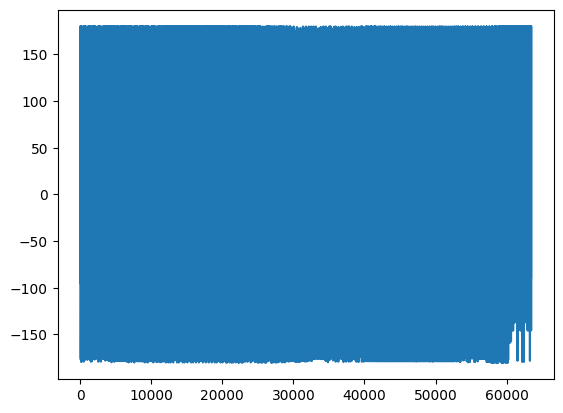

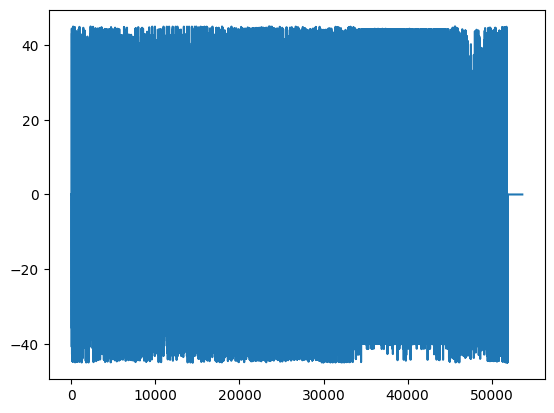

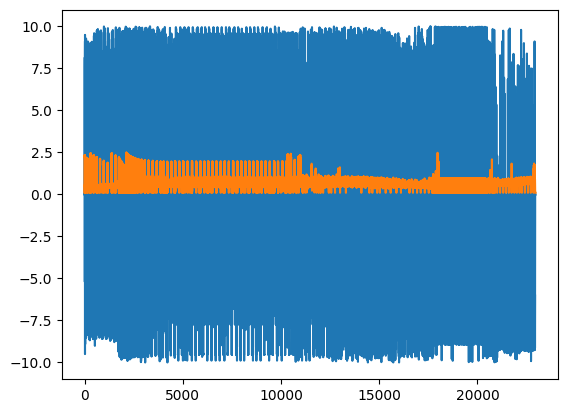

In [20]:
import matplotlib.pyplot as plt
plt.plot(asd)
plt.show()

plt.plot(asdd)
plt.show()

plt.plot(asr)
plt.show()